# CLIP Results Analysis

Analysis of CLIP data from Snowflake EDW database.

In [2]:
import snowflake.connector
import pandas as pd
import matplotlib.pyplot as plt

# Configure plot style
plt.style.use('default')
%matplotlib inline

## Connect to Snowflake

Using externalbrowser authentication with VS Code credentials.

In [3]:
# Snowflake connection using your VS Code settings
conn = snowflake.connector.connect(
    user='ALFRED_LEE',
    account='IJ90379-MISSIONLANE',
    authenticator='externalbrowser',
    database='EDW_DB',
    schema='PUBLIC'
)

print("Connected to Snowflake successfully!")

 pip install snowflake-connector-python[secure-local-storage]


Initiating login request with your identity provider. Press CTRL+C to abort and try again...
Going to open: https://missionlane.okta.com/app/snowflake/exk59w3goc3ZbUIlN357/sso/saml?SAMLRequest=nZJNc9owEIb%2Fikc92%2FIHJEUDZGgIjRsgDCadSW7CXoiKLDlaGZP%2B%2BsoQOukhOXRGB4387PqR3u1fHUrp7cGg0GpAoiAkHqhcF0JtB%2BRhNfG%2FEg8tVwWXWsGAvAKSq2EfeSkrNqrts1rCSw1oPddIITt%2BGJDaKKY5CmSKl4DM5iwbzaYsDkJWGW11riV5V%2FJ5BUcEY53huaRA4fSera0YpU3TBE0SaLOlcRiGNOxRR7XIlzN%2FcHf6gI9o2Gl5Rzh88eb2TajTE3ymtT5ByG5Xq4W%2FuM9WxBudVa%2B1wroEk4HZixweltOTADqDWZpl6f18OprfBDX6wNH6UYBKNxvJd5Drsqqt6xy4Hd1AQaXeCnf5dDwg1U4U2T4vHm9%2FyP0v8X39O7rY3T2qxbKAUkzGL%2FvZpLOJOxtzSNfmJifez3O6cZtuilhDqtpMrTsK4ws%2FjP2wt4oT5laUBL3L7hPxxi5Tobg9Vp7FS4FtK8kVBHpn%2BVGQVxX9607hsOv2mmSr8%2BRp%2FZDKedK9pIiatjGT0%2BSwo4QZ%2Fs979On7Dm%2BDOHfZpOOFliJ%2F9SbalNx%2BHF0URMcTUfibI8qg5EKOisIAootQSt1cG%2BDWzbs1NRA6PP3134kf%2FgE%3D&RelayState=ver%3A3-hint%3A98118779888126-ETMsDgAAAZxEt163ABRBRVMvQ0JDL1BLQ1M1UGFkZGluZwEAABAAEMATU30s2BKLSwZ%2BJnFV3mMAAACgFDwoE

## Execute Query

Query CLIP results data for approved CLIPs since 2025-01-01.

In [4]:
query = """
select
    left(EVALUATED_TIMESTAMP, 7) as clip_month,
    sum(clip_amount) as exposure,
    sum(case when OUTCOME = 'APPROVED' then 1 else 0 end) as num_CLIP,
    avg(case when OUTCOME = 'APPROVED' then clip_amount else 0 end) as avg_clip_amt,
    avg(pre_clip_line_limit) as avg_PCL,
    avg(DECISION_DATA:fico_08) as avg_FICO
FROM EDW_DB.PUBLIC.clip_results_data
WHERE TO_CHAR(EVALUATED_TIMESTAMP, 'YYYY-MM-DD') >= '2025-01-01'
AND (OUTCOME = 'APPROVED')
Group by 1
order by 1
"""

# Execute query
cursor = conn.cursor()
cursor.execute(query)
df = pd.DataFrame(cursor.fetchall(), columns=[col[0] for col in cursor.description])
cursor.close()
conn.close()

print(f"Query returned {len(df)} rows")

Query returned 14 rows


## View Data

In [5]:
# Display the data
df

,CLIP_MONTH,EXPOSURE,NUM_CLIP,AVG_CLIP_AMT,AVG_PCL,AVG_FICO
0,2025-01,35057750.00,33678,1040.96888176,2216.786923,651.011907
1,2025-02,38803200.00,37132,1045.00700205,2122.275935,649.161855
2,2025-03,45907000.00,42594,1077.78090811,1982.374278,647.210781
3,2025-04,45049800.00,40480,1112.89031621,1973.945158,648.810252
4,2025-05,48317250.00,44491,1086.00053943,1838.821335,647.647524
5,2025-06,47968900.00,43991,1090.42531427,1828.389898,647.323839
6,2025-07,46952450.00,42628,1101.44623252,1829.241344,647.860092
7,2025-08,63293100.00,52322,1209.68426283,2695.015481,671.624556
8,2025-09,37362950.00,34316,1088.79094300,2314.708882,656.664646
9,2025-10,37913650.00,36447,1040.24062337,2203.912531,651.783000


## Summary Statistics

In [6]:
print("=" * 50)
print("Summary Statistics")
print("=" * 50)
print(f"Total Exposure: ${df['EXPOSURE'].sum():,.2f}")
print(f"Total CLIPs: {df['NUM_CLIP'].sum():,.0f}")
print(f"Avg CLIP Amt: ${df['AVG_CLIP_AMT'].mean():,.2f}")
print(f"Avg PCL: ${df['AVG_PCL'].mean():,.2f}")
print(f"Avg FICO: {df['AVG_FICO'].mean():.1f}")
print("=" * 50)

Summary Statistics
Total Exposure: $573,203,250.00
Total CLIPs: 534,761
Avg CLIP Amt: $1,066.11
Avg PCL: $2,110.33
Avg FICO: 652.3


## Visualizations

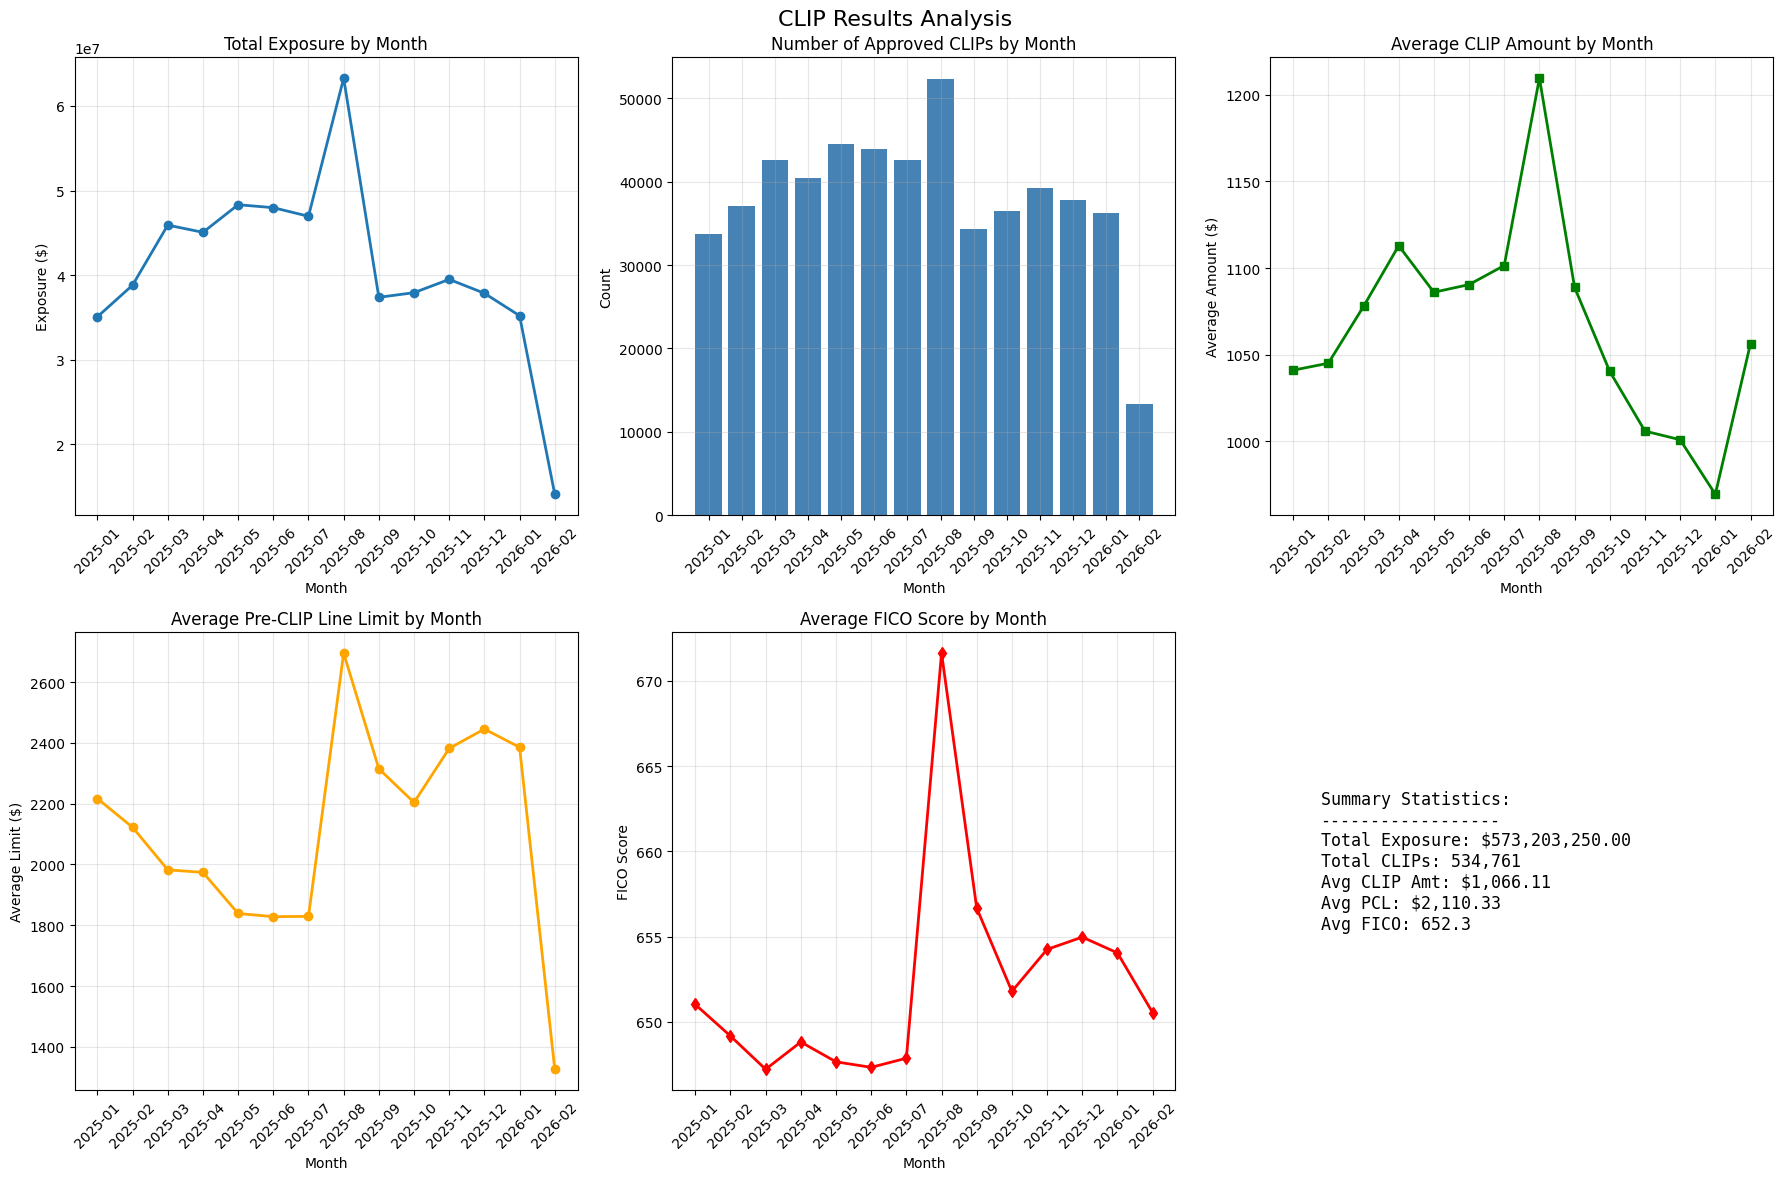

In [7]:
# Create visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('CLIP Results Analysis', fontsize=16)

# Plot 1: Exposure over time
axes[0, 0].plot(df['CLIP_MONTH'], df['EXPOSURE'], marker='o', linewidth=2)
axes[0, 0].set_title('Total Exposure by Month')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Exposure ($)')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Number of CLIPs
axes[0, 1].bar(df['CLIP_MONTH'], df['NUM_CLIP'], color='steelblue')
axes[0, 1].set_title('Number of Approved CLIPs by Month')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Average CLIP Amount
axes[0, 2].plot(df['CLIP_MONTH'], df['AVG_CLIP_AMT'], marker='s', color='green', linewidth=2)
axes[0, 2].set_title('Average CLIP Amount by Month')
axes[0, 2].set_xlabel('Month')
axes[0, 2].set_ylabel('Average Amount ($)')
axes[0, 2].tick_params(axis='x', rotation=45)
axes[0, 2].grid(True, alpha=0.3)

# Plot 4: Average Pre-CLIP Line Limit
axes[1, 0].plot(df['CLIP_MONTH'], df['AVG_PCL'], marker='o', color='orange', linewidth=2)
axes[1, 0].set_title('Average Pre-CLIP Line Limit by Month')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Average Limit ($)')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Average FICO Score
axes[1, 1].plot(df['CLIP_MONTH'], df['AVG_FICO'], marker='d', color='red', linewidth=2)
axes[1, 1].set_title('Average FICO Score by Month')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('FICO Score')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: Summary metrics
axes[1, 2].axis('off')
summary_text = f"""
Summary Statistics:
------------------
Total Exposure: ${df['EXPOSURE'].sum():,.2f}
Total CLIPs: {df['NUM_CLIP'].sum():,.0f}
Avg CLIP Amt: ${df['AVG_CLIP_AMT'].mean():,.2f}
Avg PCL: ${df['AVG_PCL'].mean():,.2f}
Avg FICO: {df['AVG_FICO'].mean():.1f}
"""
axes[1, 2].text(0.1, 0.5, summary_text, fontsize=12, family='monospace',
                verticalalignment='center')

plt.tight_layout()
plt.show()